# Data Scientist Take Home Project 

## DRONE FLIGHT DATA

Author: Aashutosh Nema

**Introduction:**

Through this report we have leveraged Data Analysis concepts to generate critical insights for our product performance i.e, Zip.
This report can be breifly divided into following categories:
- Part 1: Data Preprocessing
- Part 2: Correlation and Outliers Analysis
- Part 3: Environment Analysis and its effects on Drone Performance
- Part 4: Components Performance Analysis
- Part 5: Prediction modeling for magnitude of Distance Covered by Drone

**Part 1: Data Preprocessing**

In [7]:
#Importing the libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit
import matplotlib
import seaborn as sns
from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
from pandas.plotting import scatter_matrix
%matplotlib inline

In [12]:
#Reading the Data
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None)
summary_file = pd.read_csv(os.path.expanduser("~/Desktop/Zipline/data_scientist_take-home/summary_data.csv"))

In [13]:
#Exploring the Data
summary_file.head()
#Finding the missing values
x = summary_file.isnull().sum()
y = (x/summary_file.count().sum())*100
print(y)

,flight_id,air_temperature,battery_serial_number,body_serial_number,commit,launch_airspeed,launch_groundspeed,launch_timestamp,preflight_voltage,rel_humidity,static_pressure,wind_direction,wind_magnitude,wing_serial_number
0,16951,20.550000,15SPJJJ09036021,577350132807348254,5c504d9a16,32.453445,30.164656,2018-09-06 07:43:59 CAT,NaN,74.150000,80662.081736,-49.434555,1.949338,15SPJJJ11024054
1,16952,20.500000,15SPJJJ10029029,577209618523054122,5c504d9a16,32.141209,30.535246,2018-09-06 07:51:49 CAT,NaN,71.175044,80708.065314,-4.408768,0.917357,15SPJJJ09011032
2,16954,24.475019,15SPJJJ10012034,577209618523054122,5c504d9a16,34.701878,29.872613,2018-09-06 09:56:37 CAT,NaN,66.374982,80774.270438,-23.458781,3.788383,15SPJJJ09011032
3,16955,27.300000,15SPJJJ10054027,577209618523082792,5c504d9a16,34.368999,29.877624,2018-09-06 10:27:04 CAT,NaN,59.000000,80805.138793,-46.747881,3.921605,15SPJJJ11049056
4,16957,26.950000,15SPJJJ10050049,577348835962150933,5c504d9a16,32.898979,30.027183,2018-09-06 11:09:39 CAT,NaN,63.900000,80768.969307,-29.293360,2.975881,15SPJJJ09031032


flight_id                0.000000
air_temperature          0.000000
battery_serial_number    0.000000
body_serial_number       0.000000
commit                   0.000000
launch_airspeed          0.000000
launch_groundspeed       0.000000
launch_timestamp         0.000000
preflight_voltage        0.256328
rel_humidity             0.000000
static_pressure          0.000000
wind_direction           0.000000
wind_magnitude           0.000000
wing_serial_number       0.000000
dtype: float64


**Data Pre-Processing Steps**

- Converted timestamp to meaningful attributes extracting day, time,etc.
- Assigning the correct data types to the attributes.
- Computing distance/pos_magnitude, velocity magnitude from the flight details computed for each Flight ID.
- Imputing missing value
- Analyzing Outliers
- Imported necessary libraries to process and visualize data

In [17]:
#Imputing the missing values using mean method
summary_file.dtypes
#Imputing Missing values with mean, as it is only 0.26% of the data
summary_file['preflight_voltage'].fillna(summary_file['preflight_voltage'].mean(), inplace = True)
summary_file.isnull().sum()

flight_id                      category
air_temperature                 float64
battery_serial_number          category
body_serial_number             category
commit                           object
launch_airspeed                 float64
launch_groundspeed              float64
launch_timestamp         datetime64[ns]
preflight_voltage               float64
rel_humidity                    float64
static_pressure                 float64
wind_direction                  float64
wind_magnitude                  float64
wing_serial_number             category
dtype: object

flight_id                0
air_temperature          0
battery_serial_number    0
body_serial_number       0
commit                   0
launch_airspeed          0
launch_groundspeed       0
launch_timestamp         0
preflight_voltage        0
rel_humidity             0
static_pressure          0
wind_direction           0
wind_magnitude           0
wing_serial_number       0
dtype: int64

In [18]:
#Assigning Types to Data
summary_file['flight_id']=summary_file['flight_id'].astype('category')
summary_file['battery_serial_number']=summary_file['battery_serial_number'].astype('category')
summary_file['body_serial_number']=summary_file['body_serial_number'].astype('category')
summary_file['wing_serial_number']=summary_file['wing_serial_number'].astype('category')
summary_file['launch_timestamp']= pd.to_datetime(summary_file['launch_timestamp'])
summary_file.dtypes

flight_id                      category
air_temperature                 float64
battery_serial_number          category
body_serial_number             category
commit                           object
launch_airspeed                 float64
launch_groundspeed              float64
launch_timestamp         datetime64[ns]
preflight_voltage               float64
rel_humidity                    float64
static_pressure                 float64
wind_direction                  float64
wind_magnitude                  float64
wing_serial_number             category
dtype: object

In [21]:
#Adding Distance, Velocity and Accelaration Magnitude to the summary data set to improve the available information
#Counting the flight numbers
Iterations = summary_file['flight_id']
#looping through the flight files
for n in Iterations:
    path = "~/Desktop/Zipline/data_scientist_take-home/flight_" + str(n) + ".csv"
    flight_data = pd.read_csv(os.path.expanduser(path))
    
    #Extracting Mean magnitude of Position from file
    north_pos = flight_data["position_ned_m[0]"].mean()
    east_pos = flight_data["position_ned_m[1]"].mean()
    down_pos = flight_data["position_ned_m[2]"].mean()
    pos_mag = ((north_pos**2)+(east_pos**2)+(down_pos**2))**(1/2)
        
    summary_file.loc[summary_file["flight_id"] == n, "pos_magnitude"] = pos_mag
        
    #Extracting Mean magnitude of Velocity from file    
    north_vel = flight_data["velocity_ned_mps[0]"].mean()
    east_vel = flight_data["velocity_ned_mps[1]"].mean()
    down_vel = flight_data["velocity_ned_mps[2]"].mean()
    vel_mag = ((north_vel**2)+(east_vel**2)+(down_vel**2))**(1/2)
            
    summary_file.loc[summary_file["flight_id"] == n, "vel_magnitude"] = vel_mag
   
    #Extracting Mean magnitude of Acceleration from file
    north_accel = flight_data["accel_body_mps2[0]"].mean()
    right_accel = flight_data["accel_body_mps2[1]"].mean()
    down_accel = flight_data["accel_body_mps2[2]"].mean()
    accel_mag = ((north_accel**2)+(right_accel**2)+(down_accel**2))**(1/2)
            
    summary_file.loc[summary_file["flight_id"] == n, "accel_magnitude"] = accel_mag

summary_file.head()

,flight_id,air_temperature,battery_serial_number,body_serial_number,commit,launch_airspeed,launch_groundspeed,launch_timestamp,preflight_voltage,rel_humidity,static_pressure,wind_direction,wind_magnitude,wing_serial_number,pos_magnitude,vel_magnitude,accel_magnitude
0,16951,20.550000,15SPJJJ09036021,577350132807348254,5c504d9a16,32.453445,30.164656,2018-09-06 07:43:59,32.145665,74.150000,80662.081736,-49.434555,1.949338,15SPJJJ11024054,169.887574,21.823483,10.028606
1,16952,20.500000,15SPJJJ10029029,577209618523054122,5c504d9a16,32.141209,30.535246,2018-09-06 07:51:49,32.145665,71.175044,80708.065314,-4.408768,0.917357,15SPJJJ09011032,172.988551,22.230530,10.002967
2,16954,24.475019,15SPJJJ10012034,577209618523054122,5c504d9a16,34.701878,29.872613,2018-09-06 09:56:37,32.145665,66.374982,80774.270438,-23.458781,3.788383,15SPJJJ09011032,168.000478,21.312732,10.064213
3,16955,27.300000,15SPJJJ10054027,577209618523082792,5c504d9a16,34.368999,29.877624,2018-09-06 10:27:04,32.145665,59.000000,80805.138793,-46.747881,3.921605,15SPJJJ11049056,163.405671,20.810149,10.187113
4,16957,26.950000,15SPJJJ10050049,577348835962150933,5c504d9a16,32.898979,30.027183,2018-09-06 11:09:39,32.145665,63.900000,80768.969307,-29.293360,2.975881,15SPJJJ09031032,165.404783,21.298913,10.037307


**Inference:**
- The dataset consisted of only 0.26% Missing values which were imputed using mean of the predictor column.
- The dataset contains three categorical variables,one date-time variable and rest all numeric variables.    

**Part 2: Correlation and Outlier Analysis**

,air_temperature,launch_airspeed,launch_groundspeed,preflight_voltage,rel_humidity,static_pressure,wind_direction,wind_magnitude,pos_magnitude,vel_magnitude,accel_magnitude
air_temperature,1.000000,0.406861,-0.348050,0.083529,-0.601721,-0.259201,-0.253747,0.167628,-0.449058,-0.403464,-0.220415
launch_airspeed,0.406861,1.000000,-0.387343,0.066700,-0.245074,0.118863,0.013256,0.560727,-0.765266,-0.744559,-0.114495
launch_groundspeed,-0.348050,-0.387343,1.000000,-0.040007,0.076779,-0.105035,0.036895,-0.167412,0.656730,0.617200,0.164612
preflight_voltage,0.083529,0.066700,-0.040007,1.000000,-0.157236,-0.152949,-0.069571,0.061212,-0.014760,0.010819,0.007299
rel_humidity,-0.601721,-0.245074,0.076779,-0.157236,1.000000,0.541878,0.274522,-0.262619,0.166858,0.154991,0.143695
static_pressure,-0.259201,0.118863,-0.105035,-0.152949,0.541878,1.000000,0.172555,-0.071915,-0.166840,-0.150089,0.063975
wind_direction,-0.253747,0.013256,0.036895,-0.069571,0.274522,0.172555,1.000000,-0.111382,0.101084,0.073825,0.295463
wind_magnitude,0.167628,0.560727,-0.167412,0.061212,-0.262619,-0.071915,-0.111382,1.000000,-0.371698,-0.370366,0.077354
pos_magnitude,-0.449058,-0.765266,0.656730,-0.014760,0.166858,-0.166840,0.101084,-0.371698,1.000000,0.969731,0.272885
vel_magnitude,-0.403464,-0.744559,0.617200,0.010819,0.154991,-0.150089,0.073825,-0.370366,0.969731,1.000000,0.263534


<Figure size 1080x1080 with 0 Axes>

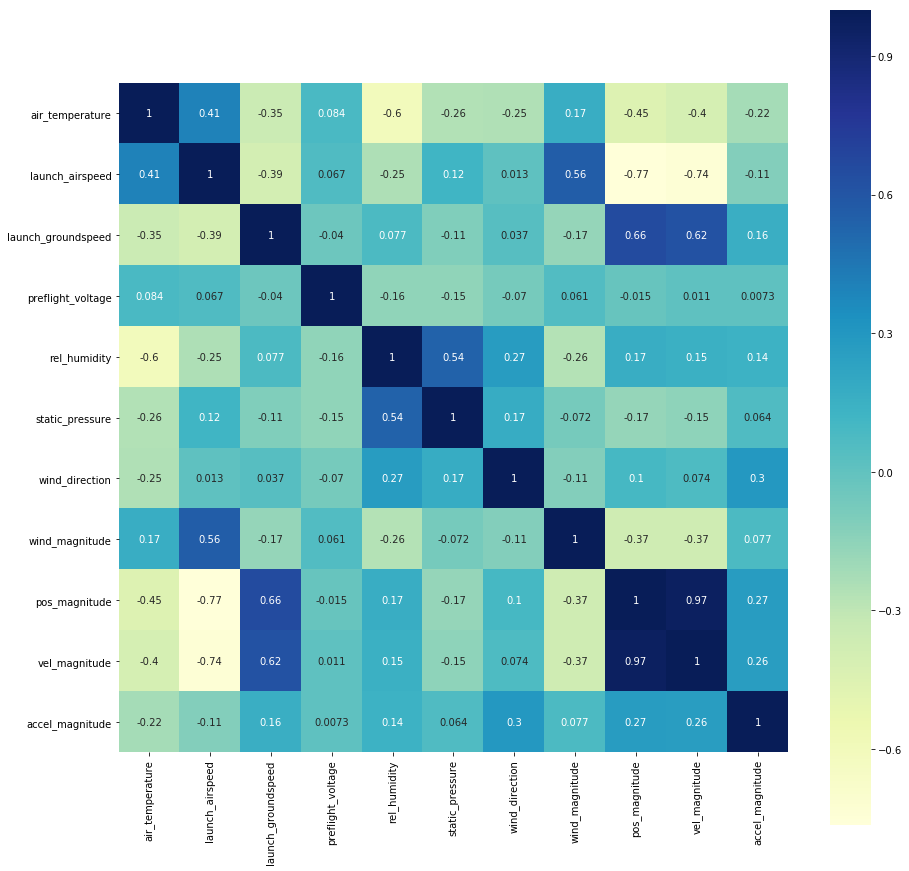

In [22]:
#Checking for correlation & Data distribution
summary_1 = summary_file.drop(['flight_id','battery_serial_number','body_serial_number','commit','launch_timestamp','wing_serial_number'],axis = 1)
#Correlation values
summary_1.corr()
#Correlation plot
plt.figure(figsize=(15,15))
sns.heatmap(summary_1.corr(),annot=True, square = True, cmap="YlGnBu") 
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FC22C0F5F8>,
      dtype=object)

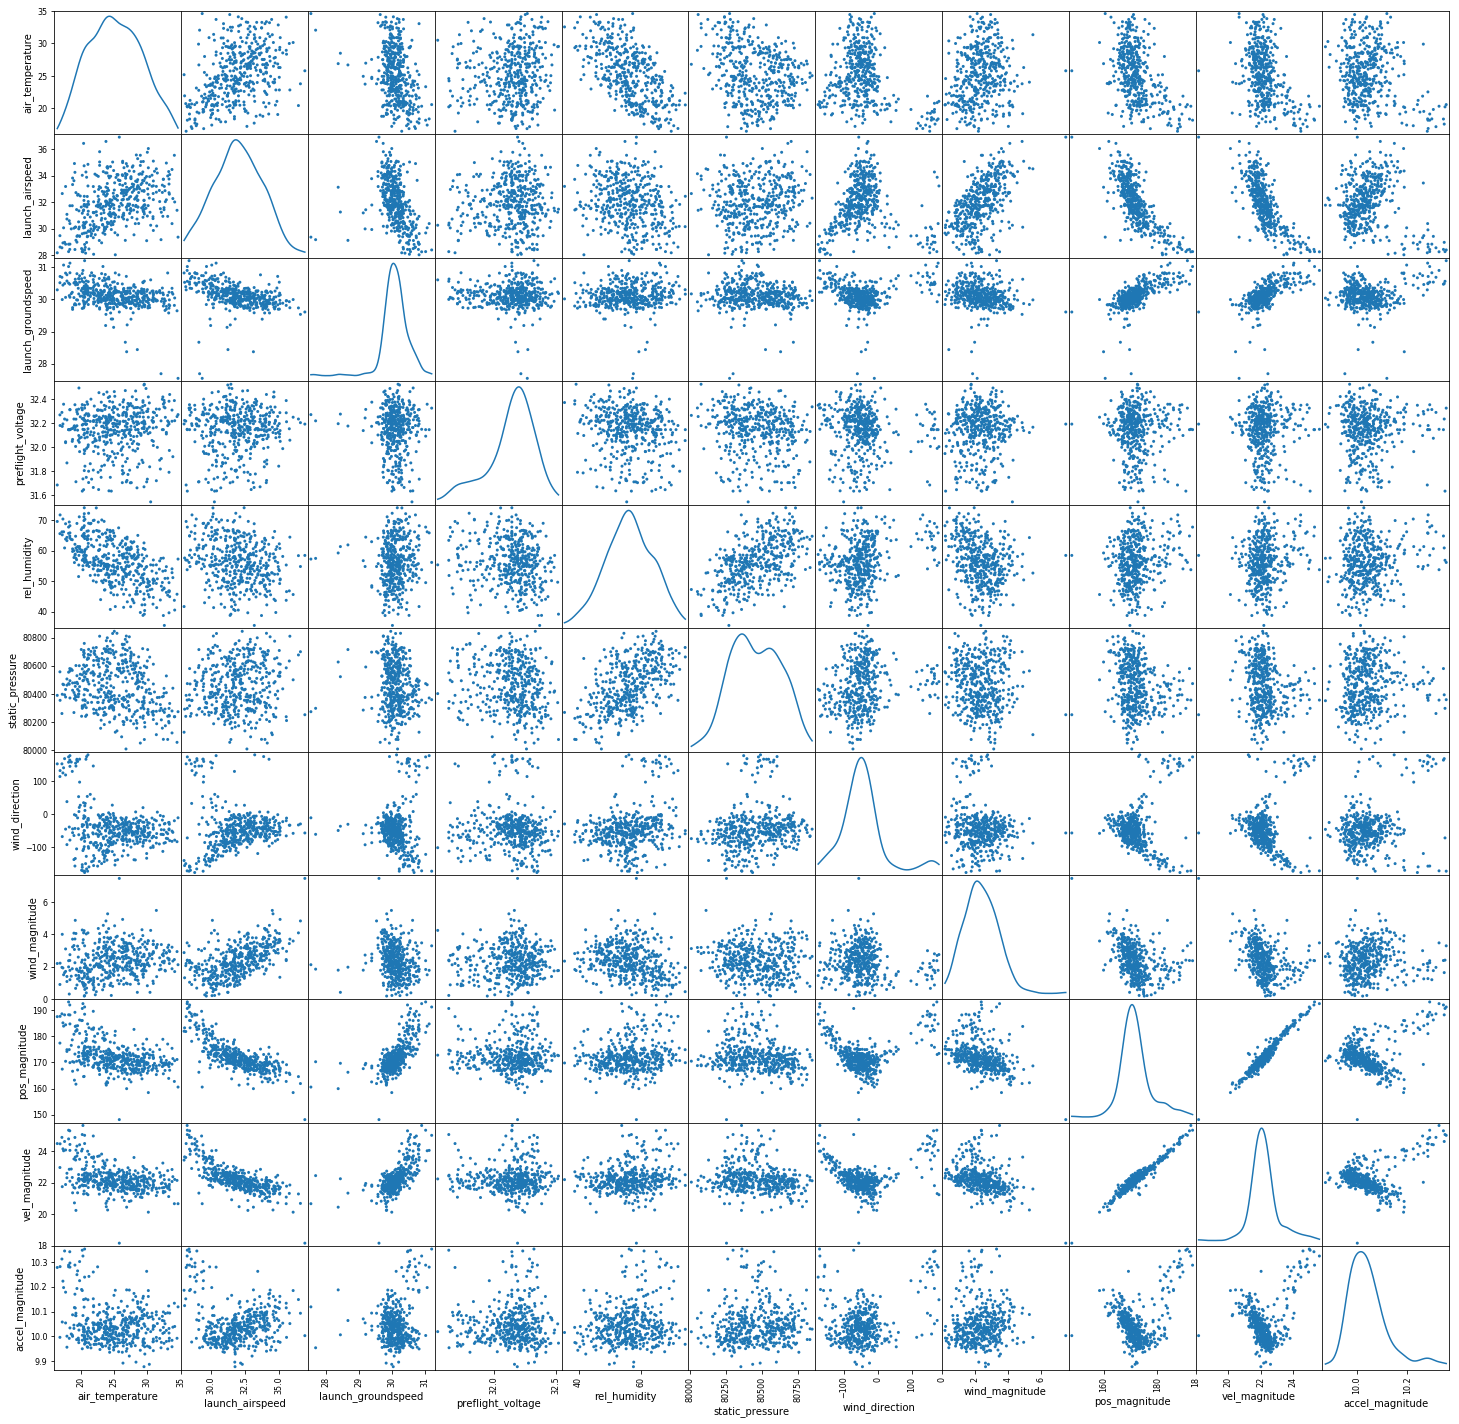

In [23]:
scatter_matrix(summary_1, alpha=1, figsize=(25, 25), diagonal='kde')

**Inferences:**

Correlation can help us asses linear relationship between two continuous variables.
Based on the plots we can conclude that:
- There exists very strong positive correlation between Position and Velocity magnitudes.
- There is strong negetive correlation between: Velocity magnitude & Launch Airspeed, position magnitude & launch air speed.
- There is moderate positive correlation between: Launch Ground speed & Velocity Magnitude, Launce Ground Speed & Position Magnitude, Launch airspeed & wind magnitude, relative humidity & static pressure.
- There is moderate negative correlation between: Relative humidity & Air temperature


{'whiskers': [<matplotlib.lines.Line2D at 0x1fc26b1ee80>,
 'caps': [<matplotlib.lines.Line2D at 0x1fc26b3d828>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fc26b1ed30>],
 'medians': [<matplotlib.lines.Line2D at 0x1fc26b3deb8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1fc26b3df98>],
 'means': []}

Text(0, 0.5, 'Distance in meters')

Text(0.5, 0, 'Standard Deviation: 5.7')

Text(0.5, 1.0, 'Box Plot of Distance covered by Dron Flights')

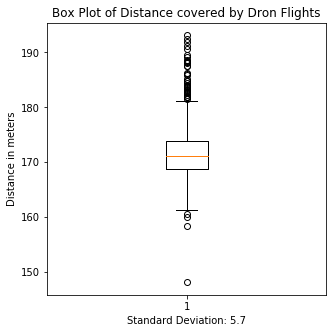

In [24]:
#Checking outlier conditions for Drone Launches
#Outliers for distance covered by Drones
fig = plt.subplots(figsize = (5,5))
deviation = summary_file['pos_magnitude'].values.std(ddof=1)
xlab = "Standard Deviation: " + str(deviation)[0:3]

plt.boxplot(summary_file['pos_magnitude'])
plt.ylabel("Distance in meters")
plt.xlabel(xlab)
plt.title("Box Plot of Distance covered by Dron Flights")

{'whiskers': [<matplotlib.lines.Line2D at 0x1fc26b58390>,
 'caps': [<matplotlib.lines.Line2D at 0x1fc26b58a20>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fc26b55f60>],
 'medians': [<matplotlib.lines.Line2D at 0x1fc26b58e48>],
 'fliers': [<matplotlib.lines.Line2D at 0x1fc26b5d438>],
 'means': []}

Text(0, 0.5, 'Voltage')

Text(0.5, 0, 'Standard Deviation: 0.1')

Text(0.5, 1.0, 'Preflight Voltage Box Plot')

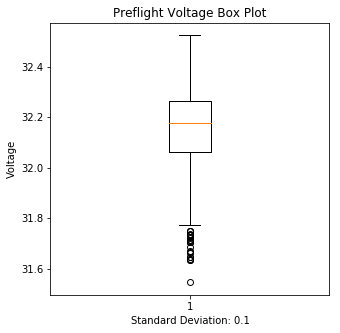

In [25]:
#Outliers for preflight voltages
fig = plt.subplots(figsize = (5,5))
deviation = summary_file['preflight_voltage'].values.std(ddof=1)
xlab = "Standard Deviation: " + str(deviation)[0:3]

plt.boxplot(summary_file['preflight_voltage'])
plt.ylabel("Voltage")
plt.xlabel(xlab)
plt.title("Preflight Voltage Box Plot")

{'whiskers': [<matplotlib.lines.Line2D at 0x1fc25d51550>,
 'caps': [<matplotlib.lines.Line2D at 0x1fc25d51be0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fc25d51128>],
 'medians': [<matplotlib.lines.Line2D at 0x1fc25d582b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1fc25d585f8>],
 'means': []}

Text(0, 0.5, 'Launch Airspeed')

Text(0.5, 0, 'Standard Deviation: 1.7')

Text(0.5, 1.0, 'Box Plot for Launch Airspeed')

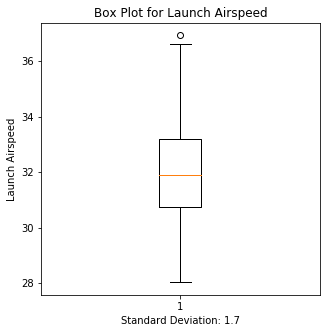

In [26]:
#Outliers for launch airspeed
fig = plt.subplots(figsize = (5,5))
deviation = summary_file['launch_airspeed'].values.std(ddof=1)
xlab = "Standard Deviation: " + str(deviation)[0:3]

plt.boxplot(summary_file['launch_airspeed'])
plt.ylabel("Launch Airspeed")
plt.xlabel(xlab)
plt.title("Box Plot for Launch Airspeed")

{'whiskers': [<matplotlib.lines.Line2D at 0x1fc25d946d8>,
 'caps': [<matplotlib.lines.Line2D at 0x1fc25d94d68>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fc25d942e8>],
 'medians': [<matplotlib.lines.Line2D at 0x1fc25d9c438>],
 'fliers': [<matplotlib.lines.Line2D at 0x1fc25d9c780>],
 'means': []}

Text(0, 0.5, 'Launch Groundspeed')

Text(0.5, 0, 'Standard Deviation: 0.3')

Text(0.5, 1.0, 'Box Plot for Launch Groundspeed')

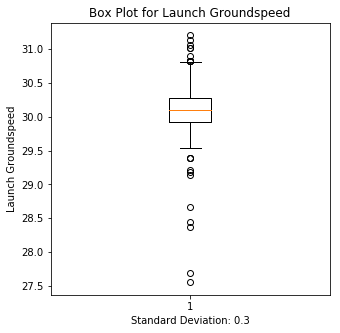

In [27]:
#Outliers for launch groundspeed
fig = plt.subplots(figsize = (5,5))
deviation = summary_file['launch_groundspeed'].values.std(ddof=1)
xlab = "Standard Deviation: " + str(deviation)[0:3]

plt.boxplot(summary_file['launch_groundspeed'])
plt.ylabel("Launch Groundspeed")
plt.xlabel(xlab)
plt.title("Box Plot for Launch Groundspeed")

**Inference**
We have used 3 standard deviations to calculate outliers. Based on the plots it can be infered that:
- Majority of the flights travel a distance between 168 to 175 meters. High number of outliers can be found in the plot in this category which suggests it is common for flights to take longer routes which might be due to weather conditions or operating limitations.
- Preflight voltages have a median of around 32 Volts. It is found that outliers in this category are only below the minimum voltage for the group. Which suggests that battery providinng higher than the required voltage is never a problem for the drone, but there are situations when the drone is receiveing less than the necessary Voltage. Hence drones should be made safe to low voltage conditions.
- For launch airspeed it is found that there is only one outlier rest all launches are within the interval limits.
- Ground speed charecteristic of the drone has most number of outliers, hence this suggests imporvement is needed to increase ground performance of the Drone.

**Part 3: Environment Analysis and its effects on Drone Performance**


In [28]:
#Diurnal weather patterns
summary_file['launch_month']=summary_file['launch_timestamp'].dt.month
summary_file['launch_day']=summary_file['launch_timestamp'].dt.day
summary_file['launch_dayofweek']=summary_file['launch_timestamp'].dt.weekday_name
summary_file['launch_hour']=summary_file['launch_timestamp'].dt.hour

<Figure size 1800x1800 with 0 Axes>

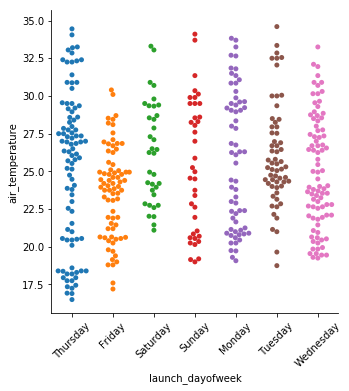

In [29]:
#Relation between weather and day
fig = plt.figure(figsize=(25, 25))
sns.catplot(x="launch_dayofweek", y="air_temperature", hue="launch_dayofweek", kind="swarm", data=summary_file).set_xticklabels(rotation=45)


It is found that the temperature varies the most on thursday and least on saturday. On Friday typically average or lower than average temperature  is observed. On below figure we can see the temperature varying as expected throughout the day

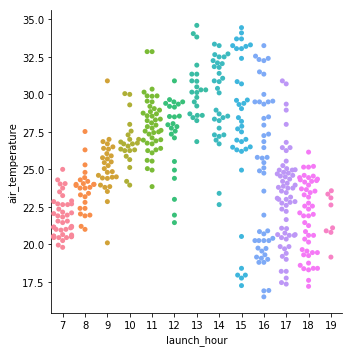

In [30]:
#Air temperature and Time of Day
sns.catplot(x="launch_hour",y="air_temperature", kind="swarm",data=summary_file)

In [31]:
temp_plot = summary_file.groupby('launch_dayofweek')['air_temperature','rel_humidity', 'static_pressure', 'wind_direction', 'wind_magnitude'].mean().reset_index()

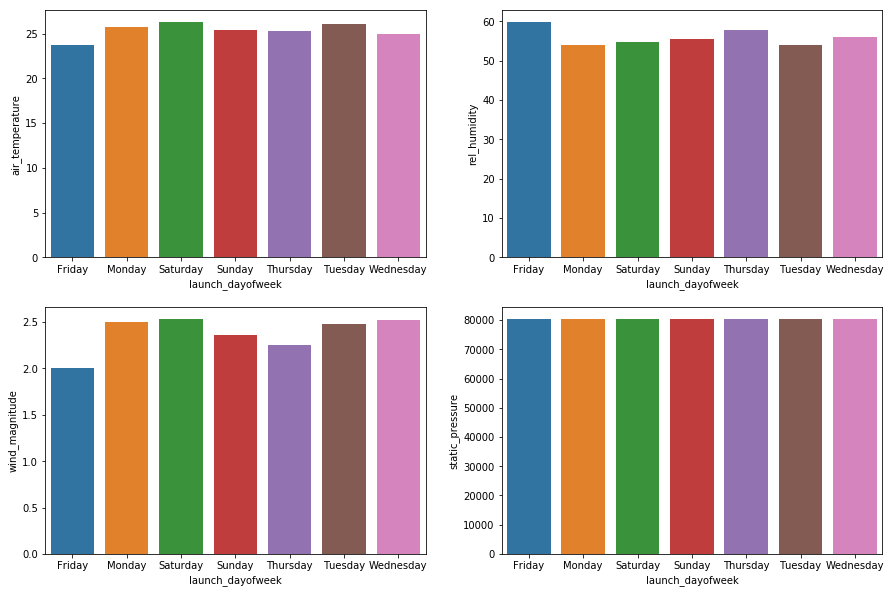

In [32]:
#Plotting the launch conditions as per day.
fig, axs = plt.subplots(ncols=2, nrows=2, figsize = (15,10))
sns.barplot(x='launch_dayofweek', y='air_temperature', data=temp_plot, ax=axs[0,0])
sns.barplot(x='launch_dayofweek', y='rel_humidity', data=temp_plot, ax=axs[0,1])
sns.barplot(x='launch_dayofweek',y='static_pressure', data=temp_plot, ax=axs[1,1])
sns.barplot(x='launch_dayofweek',y='wind_magnitude', data=temp_plot, ax=axs[1,0])

Static pressure remains fiarly constant throughout the week

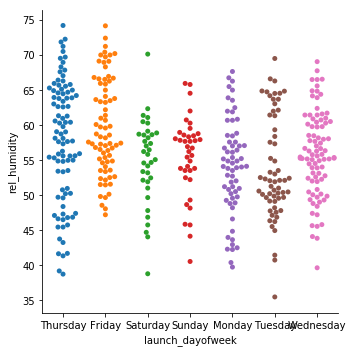

In [33]:
sns.catplot(x='launch_dayofweek', y='rel_humidity', kind = 'swarm', data = summary_file)

It can be infered the relative humidity varies a bit opposite to air temperature throughout the week, which is also suggested by moderate negative correlation of -0.6 between them. While it can also be observed from the figure below that relative humidity is high during the morning and then decreases with the increase in temperature during the day time.

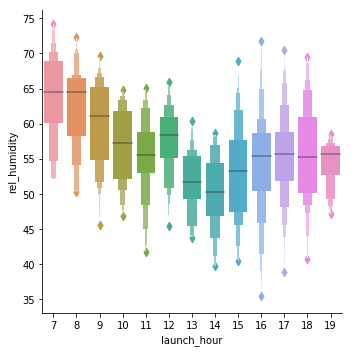

In [34]:
#Relative Humidity Vs Time of day
sns.catplot(x="launch_hour",y="rel_humidity", kind="boxen",data=summary_file)

<Figure size 640x480 with 0 Axes>

Text(0.5, 0, 'Relative Humidity')

Text(0.5, 0, 'Temperature')

Text(0.5, 0, 'Launch_hour')

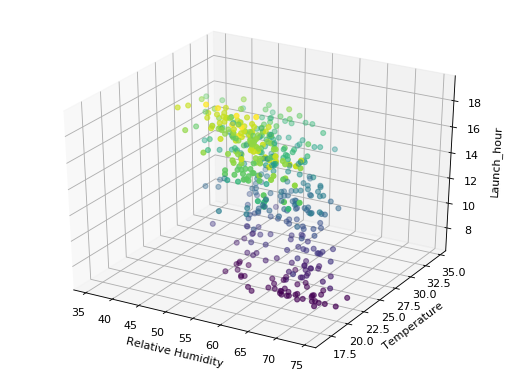

<Figure size 2880x2880 with 0 Axes>

In [35]:
#3D plot between relative humidity air temperature and time of day
from mpl_toolkits import mplot3d
from matplotlib.pyplot import figure

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = summary_file["launch_hour"]
xdata = summary_file["rel_humidity"]
ydata = summary_file["air_temperature"]
ax.set_xlabel('Relative Humidity')
ax.set_ylabel('Temperature')
ax.set_zlabel('Launch_hour')
fig = plt.figure(figsize=(40, 40))
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='viridis')

C:\Users\vasuk\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


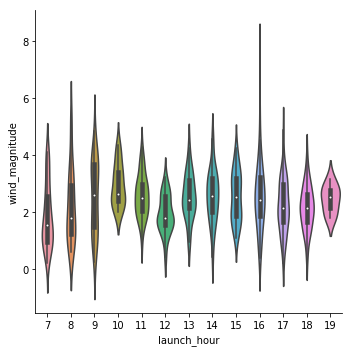

In [36]:
#Windspeed vs Time of day
sns.catplot(x="launch_hour",y="wind_magnitude", kind="violin",data=summary_file)

During Morning hours the wind speed is slow which increases with the time of the day, wind speed is most fluctuating during the afternoon hours specially around 4 PM. The next plot tries to generate a relation between air temperature and wind magnitude but as the correlation suggests the two are weekly correlated (Correlation = 0.17)

<Figure size 2160x360 with 0 Axes>

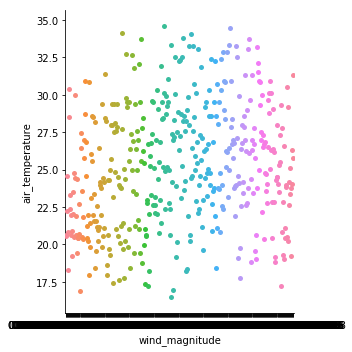

In [37]:
#Relation between wind speed and temperature
fig = plt.figure(figsize=(30, 5))
sns.catplot(x ='wind_magnitude', y = 'air_temperature', kind = 'strip', data = summary_file)

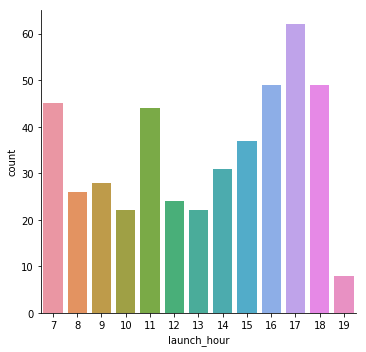

In [38]:
#Environment and Drone Flight Characteristics
#Launch vs Time of Day
sns.catplot(x="launch_hour",kind="count", data=summary_file)

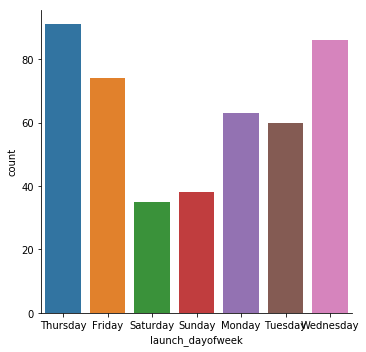

In [39]:
#Launch VS Week of Day
sns.catplot(x="launch_dayofweek",kind="count", data=summary_file)

Most launches takes place the morning and evening hours. Juding from the pattern of demand we can infer that most accidents and injuries ocuur during the early morning and the evening time. Also the most requirement of Drone is during Thursday followed by Wednesday and Friday. Saturday and Sunday are the least requirement days. This suggestes that most of the accidents and injuries usually occur while commuting to and from workplace. Expectedly the high traffic times increases the chances of accidents

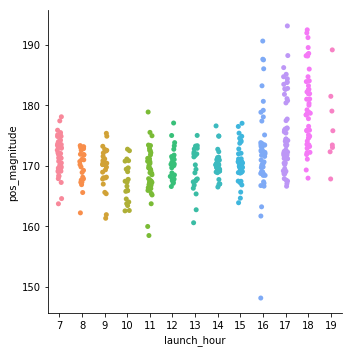

In [40]:
#Distance covered vs time of Day
sns.catplot(x="launch_hour",y="pos_magnitude", kind="strip",data=summary_file)

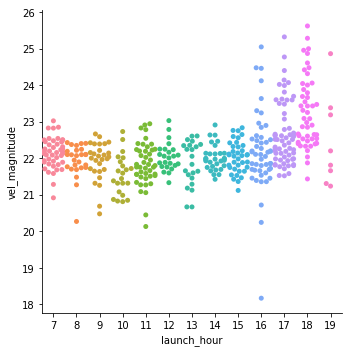

In [41]:
#Velocity Magnitude VS hour of Day
sns.catplot(x="launch_hour",y="vel_magnitude", kind="swarm",data=summary_file)

<Figure size 2160x360 with 0 Axes>

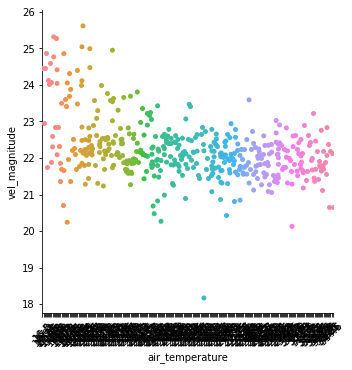

In [42]:
#Temperature VS Velocity

summary_file['air_temperature'] = summary_file['air_temperature'].round(2)
fig = plt.figure(figsize=(30, 5))
sns.catplot(x="air_temperature",y="vel_magnitude", kind="swarm",data=summary_file).set_xticklabels(rotation=45)

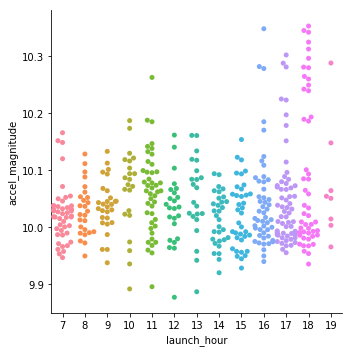

In [43]:
#Accelaration VS Time of Day
sns.catplot(x="launch_hour",y="accel_magnitude", kind="swarm",data=summary_file)

The Drones delivering during the evening cover the most distance. Similarly the velocity and accelaration of drone is highest in the evening. This suggests evening time i.e., low temperature and moderate humidity are favourable operating conditions for the Drone.

**Part 4: Component Performance Analysis**

In [44]:
#Performace of Parts
#Defining a function to plot multiple relations
def fun_attribute(type_no,attribute,dataframe,xname,yname,title):
    a=dataframe.groupby(type_no)[attribute].sum().reset_index()
    temp=pd.DataFrame(a)
    temp = temp.sort_values(by=[attribute])
    fig = plt.figure(figsize=(15, 5))
    ax =sns.barplot(data=summary_file,y=attribute,x=type_no,orient="v")
    plt.xlabel(xname)
    plt.ylabel(yname)
    plt.title(title)
    plt.setp(ax.get_xticklabels(), rotation=45)

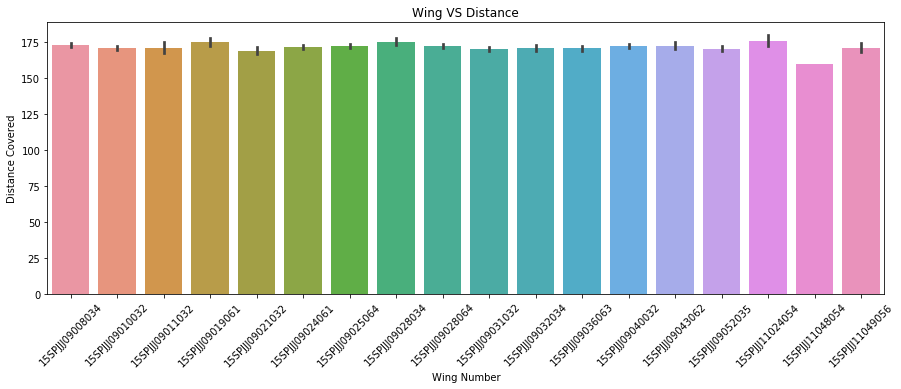

In [45]:
#for Wing and Distance Covered
fun_attribute("wing_serial_number","pos_magnitude",summary_file, "Wing Number", 'Distance Covered', 'Wing VS Distance')

In [46]:
#Finding the Min and Max
eval_1 = summary_file.groupby('wing_serial_number')['pos_magnitude'].sum()
eval_1.max()
eval_1.min()

11246.157758783347

159.94933184793263

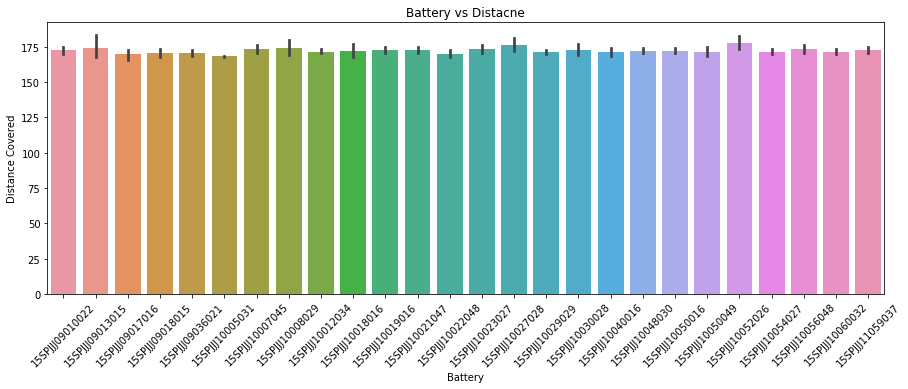

In [47]:
#for Battery and Distance covered
fun_attribute("battery_serial_number","pos_magnitude",summary_file, 'Battery', 'Distance Covered', 'Battery vs Distacne')

In [48]:
#Finding the Min and Max
eval_2 = summary_file.groupby('battery_serial_number')['pos_magnitude'].sum()
eval_2.max()
eval_2.min()

5317.824231508473

504.46735771234705

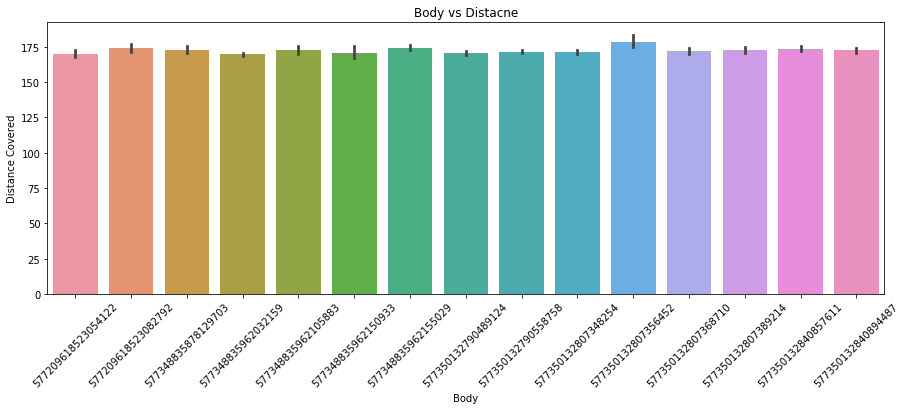

In [49]:
fun_attribute("body_serial_number","pos_magnitude",summary_file, 'Body', 'Distance Covered', 'Body vs Distacne')

In [50]:
#Finding the Min and Max
eval_3 = summary_file.groupby('body_serial_number')['pos_magnitude'].sum()
eval_3.max()
eval_3.min()

11843.616109092836

510.6920818802824

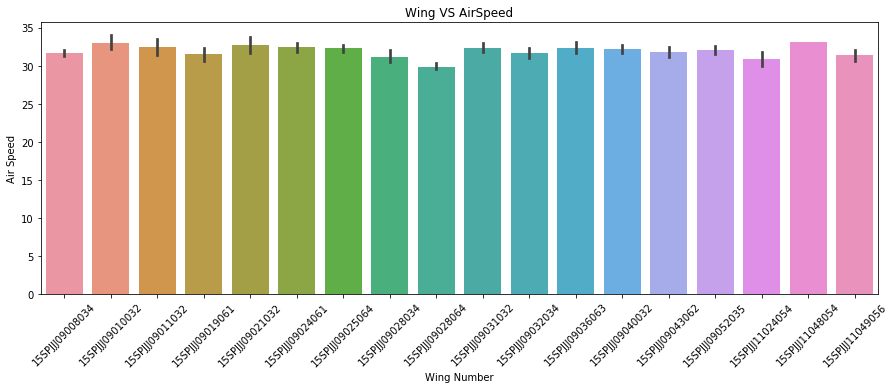

In [51]:
fun_attribute("wing_serial_number","launch_airspeed",summary_file, "Wing Number", 'Air Speed', 'Wing VS AirSpeed')

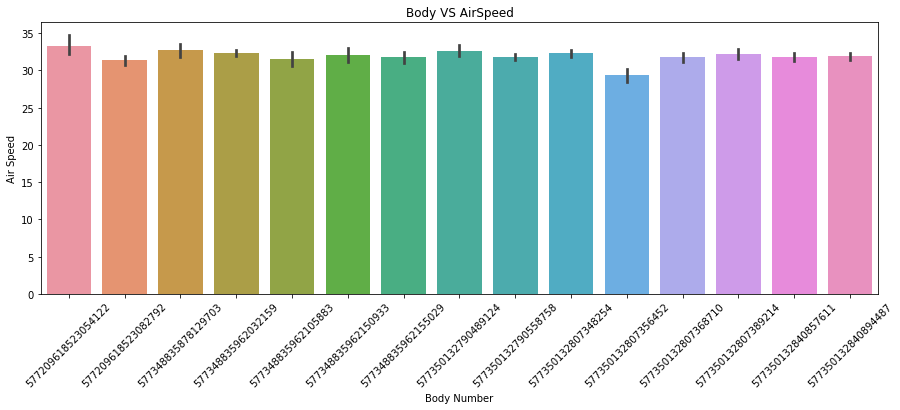

In [52]:
fun_attribute("body_serial_number","launch_airspeed",summary_file, "Body Number", 'Air Speed', 'Body VS AirSpeed')

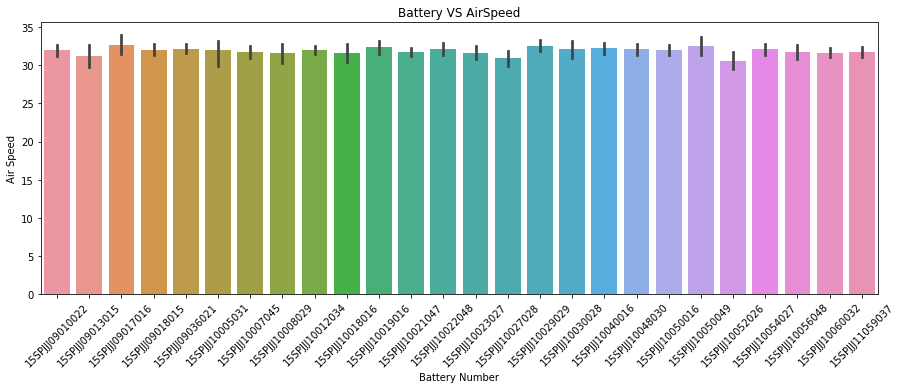

In [53]:
fun_attribute("battery_serial_number","launch_airspeed",summary_file, "Battery Number", 'Air Speed', 'Battery VS AirSpeed')

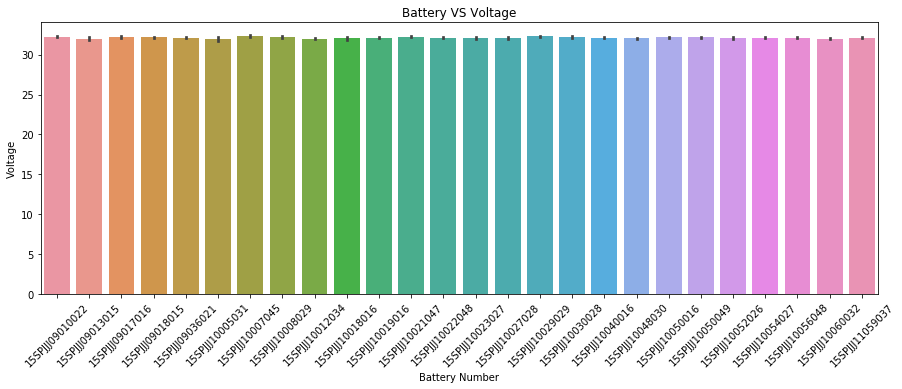

In [54]:
fun_attribute("battery_serial_number","preflight_voltage",summary_file, "Battery Number", 'Voltage', 'Battery VS Voltage')

**Inference:**

The part performances do not seem to vary by a great scale which suggests that almost all of the Zips function as designed which is a good this. The following observations can be made from the plots:

Wing observations:
- Wing Number 15SPJJJ11024054 has the largest distance covered with magnitude 11246.16 meters and wing 15SPJJJ11048054 has covered the least distance of all with magnitude 159.95 meters.
- Wing number 15SPJJJ11048054 has the highest air speed achieved and wing 15SPJJJ09031032 has the lowest airspeed achieved

Battery observations:
- Similarly Battery 15SPJJJ10052026 has the largest distance covered 5317.82 meters while 15SPJJJ10005031 has the shortest distance covered 504.47 meters. 
- The mean voltage provided by all batteries is about the same which suggests that all battery work perfectly well providing a constant voltage.

Body Observations:
- Body 577350132807368710 has the largest distance covered of 11843.62 and body 577209618523054122 has the smallest distance covered of 510.69 meters
- Body 577350132807356452 has the lowest air speed and body 577209618523054122 has achieved highest airspeed

**Part 5: Developing a Regression Model**

**Model Summary** 

- 10 fold CV 
- Neural Networks used:  [(3),(4),(5),(3,2),(4,3),(5,4),(6,5),(7,6),(9,8),(12,11)]
- Activation: RELU, Solver: lbfgs

- Best result observed for neurons=6,5
- Test Data set prediction with average 63% observed
- Features Excluded : 'flight_id','commit','launch_timestamp','vel_magnitude','accel_magnitude','launch_month','launch_dayofweek','launch_airspeed','launch_groundspeed'


In [131]:
#Importing Libraries for Model Building - Neural Networks
import AdvancedAnalytics
from AdvancedAnalytics import NeuralNetwork
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import math

In [147]:
#Developing a model to predict distance for a particular drone
df = summary_file.drop(['flight_id','commit','launch_timestamp','vel_magnitude','accel_magnitude','launch_month','launch_dayofweek','launch_airspeed','launch_groundspeed'], axis = 1)

In [148]:
df.head()

,air_temperature,battery_serial_number,body_serial_number,preflight_voltage,rel_humidity,static_pressure,wind_direction,wind_magnitude,wing_serial_number,pos_magnitude,launch_day,launch_hour
0,20.55,15SPJJJ09036021,577350132807348254,32.145665,74.150000,80662.081736,-49.434555,1.949338,15SPJJJ11024054,169.887574,6,7
1,20.50,15SPJJJ10029029,577209618523054122,32.145665,71.175044,80708.065314,-4.408768,0.917357,15SPJJJ09011032,172.988551,6,7
2,24.48,15SPJJJ10012034,577209618523054122,32.145665,66.374982,80774.270438,-23.458781,3.788383,15SPJJJ09011032,168.000478,6,9
3,27.30,15SPJJJ10054027,577209618523082792,32.145665,59.000000,80805.138793,-46.747881,3.921605,15SPJJJ11049056,163.405671,6,10
4,26.95,15SPJJJ10050049,577348835962150933,32.145665,63.900000,80768.969307,-29.293360,2.975881,15SPJJJ09031032,165.404783,6,11


In [150]:
#Converting Categorical Variables - One Hot Encoding
df_new = pd.get_dummies(df, prefix_sep='_', drop_first=True)

df_new.head()

,air_temperature,preflight_voltage,rel_humidity,static_pressure,wind_direction,wind_magnitude,pos_magnitude,launch_day,launch_hour,battery_serial_number_15SPJJJ09013015,battery_serial_number_15SPJJJ09017016,battery_serial_number_15SPJJJ09018015,battery_serial_number_15SPJJJ09036021,battery_serial_number_15SPJJJ10005031,battery_serial_number_15SPJJJ10007045,battery_serial_number_15SPJJJ10008029,battery_serial_number_15SPJJJ10012034,battery_serial_number_15SPJJJ10018016,battery_serial_number_15SPJJJ10019016,battery_serial_number_15SPJJJ10021047,battery_serial_number_15SPJJJ10022048,battery_serial_number_15SPJJJ10023027,battery_serial_number_15SPJJJ10027028,battery_serial_number_15SPJJJ10029029,battery_serial_number_15SPJJJ10030028,battery_serial_number_15SPJJJ10040016,battery_serial_number_15SPJJJ10048030,battery_serial_number_15SPJJJ10050016,battery_serial_number_15SPJJJ10050049,battery_serial_number_15SPJJJ10052026,battery_serial_number_15SPJJJ10054027,battery_serial_number_15SPJJJ10056048,battery_serial_number_15SPJJJ10060032,battery_serial_number_15SPJJJ11059037,body_serial_number_577209618523082792,body_serial_number_577348835878129703,body_serial_number_577348835962032159,body_serial_number_577348835962105883,body_serial_number_577348835962150933,body_serial_number_577348835962155029,body_serial_number_577350132790489124,body_serial_number_577350132790558758,body_serial_number_577350132807348254,body_serial_number_577350132807356452,body_serial_number_577350132807368710,body_serial_number_577350132807389214,body_serial_number_577350132840857611,body_serial_number_577350132840894487,wing_serial_number_15SPJJJ09010032,wing_serial_number_15SPJJJ09011032,wing_serial_number_15SPJJJ09019061,wing_serial_number_15SPJJJ09021032,wing_serial_number_15SPJJJ09024061,wing_serial_number_15SPJJJ09025064,wing_serial_number_15SPJJJ09028034,wing_serial_number_15SPJJJ09028064,wing_serial_number_15SPJJJ09031032,wing_serial_number_15SPJJJ09032034,wing_serial_number_15SPJJJ09036063,wing_serial_number_15SPJJJ09040032,wing_serial_number_15SPJJJ09043062,wing_serial_number_15SPJJJ09052035,wing_serial_number_15SPJJJ11024054,wing_serial_number_15SPJJJ11048054,wing_serial_number_15SPJJJ11049056
0,20.55,32.145665,74.150000,80662.081736,-49.434555,1.949338,169.887574,6,7,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,20.50,32.145665,71.175044,80708.065314,-4.408768,0.917357,172.988551,6,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,24.48,32.145665,66.374982,80774.270438,-23.458781,3.788383,168.000478,6,9,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,27.30,32.145665,59.000000,80805.138793,-46.747881,3.921605,163.405671,6,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,26.95,32.145665,63.900000,80768.969307,-29.293360,2.975881,165.404783,6,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [156]:
varlist = ['pos_magnitude']
dropvarlist=[]
X = df_new.drop(['pos_magnitude'], axis = 1)
y = df_new['pos_magnitude']
np_y = np.ravel(y)

In [162]:
# Cross-Validation
network_list = [(3), (4), (5), (3,2), (4,3), (5,4), (6,5),(7,6),(9,8),(12,11)]
# Scoring for Interval Prediction Neural Networks
score_list = ['neg_mean_squared_error', 'neg_mean_absolute_error']
score_names = ['ASE', 'MAD']
for nn in network_list:
    print("\nNetwork: ", nn)
    fnn = MLPRegressor(hidden_layer_sizes=nn, activation='relu', alpha=0.0, solver='lbfgs', max_iter=5000, random_state=12345)
    mean_score = [ ]
    std_score = [ ]
    for i in range(len(score_list)):
        scores = cross_val_score(fnn,X,np_y,scoring=score_list[i],cv=10)
        mean_score.append(scores.mean())
        std_score.append (scores.std())
    print("{:.<10s}{:>6s}{:>13s}".format("Metric", "Mean", "Std. Dev."))
    for i in range(2):
        mean = math.fabs(mean_score[i])
        std = std_score[i]
        print("{:.<10s}{:>6.4f}{:>13.4f}".format(score_names[i],mean,std))


Network:  3
Metric....  Mean    Std. Dev.
ASE.......24.5485       9.4160
MAD.......3.6585       0.6908

Network:  4
Metric....  Mean    Std. Dev.
ASE.......33.0849      14.0158
MAD.......4.1026       0.8566

Network:  5
Metric....  Mean    Std. Dev.
ASE.......27.1301      14.9502
MAD.......3.7954       0.8431

Network:  (3, 2)
Metric....  Mean    Std. Dev.
ASE.......33.0849      14.0158
MAD.......4.1026       0.8566

Network:  (4, 3)
Metric....  Mean    Std. Dev.
ASE.......33.0849      14.0158
MAD.......4.1026       0.8566

Network:  (5, 4)
Metric....  Mean    Std. Dev.
ASE.......33.0849      14.0158
MAD.......4.1026       0.8566

Network:  (6, 5)
Metric....  Mean    Std. Dev.
ASE.......20.8481       7.6627
MAD.......3.4839       0.5968

Network:  (7, 6)
Metric....  Mean    Std. Dev.
ASE.......22.8044       8.3363
MAD.......3.5991       0.6521

Network:  (9, 8)
Metric....  Mean    Std. Dev.
ASE.......28.4608      13.1608
MAD.......3.8836       0.8750

Network:  (12, 11)
Metric....  Me

In [160]:
X_train, X_validate, y_train, y_validate = train_test_split(X,np_y,test_size = 0.3, random_state=12345)
fnn = MLPRegressor(hidden_layer_sizes=(6,5), activation='relu', alpha=0.0, solver='lbfgs', max_iter=5000, random_state=12345)
fnn = fnn.fit(X_train,y_train)
NeuralNetwork.display_split_metrics(fnn, X_train, y_train, X_validate, y_validate)



Model Metrics..........       Training     Validation
Observations...........            312            135
Features...............             64             64
Number of Layers.......              2              2
Number of Neurons......             11             11
Number of Outputs......              1              1
Number of Weights......            431            431
Number of Iterations...           1189           1189
Activation Function....           relu           relu
Loss...................         6.7421
R-Squared..............         0.5904         0.6377
Mean Absolute Error....         2.6949         2.5917
Median Absolute Error..         2.2171         2.1647
Avg Squared Error......        13.4842        11.3793
Square Root ASE........         3.6721         3.3733


- Achieved 63.77% R2 for validation with Layer (6,5)

## Summary: 


**Part 1: Data Preprocessing**
- The dataset consisted of only 0.26% Missing values which were imputed using mean of the predictor column.
- The dataset contains three categorical variables,one date-time variable and rest all numeric variables.

**Part 2: Correlation and Outlier Analysis**

Correlation can help us asses linear relationship between two continuous variables.
Based on the plots we can conclude that:
- There exists very strong positive correlation between Position and Velocity magnitudes.
- There is strong negetive correlation between: Velocity magnitude & Launch Airspeed, position magnitude & launch air speed.
- There is moderate positive correlation between: Launch Ground speed & Velocity Magnitude, Launce Ground Speed & Position Magnitude, Launch airspeed & wind magnitude, relative humidity & static pressure.
- There is moderate negative correlation between: Relative humidity & Air temperature

We have used 3 standard deviations to calculate outliers. Based on the plots it can be infered that:
- Majority of the flights travel a distance between 168 to 175 meters. High number of outliers can be found in the plot in this category which suggests it is common for flights to take longer routes which might be due to weather conditions or operating limitations.
- Preflight voltages have a median of around 32 Volts. It is found that outliers in this category are only below the minimum voltage for the group. Which suggests that battery providinng higher than the required voltage is never a problem for the drone, but there are situations when the drone is receiveing less than the necessary Voltage. Hence drones should be made safe to low voltage conditions.
- For launch airspeed it is found that there is only one outlier rest all launches are within the interval limits.
- Ground speed charecteristic of the drone has most number of outliers, hence this suggests imporvement is needed to increase ground performance of the Drone.

**Part 3: Environment Analysis and its effects on Drone Performance**

- It is found that the temperature varies the most on thursday and least on saturday. On Friday typically average or lower than average temperature  is observed. On below figure we can see the temperature varying as expected throughout the day

- It can be infered the relative humidity varies a bit opposite to air temperature throughout the week, which is also suggested by moderate negative correlation of -0.6 between them. While it can also be observed from the figure below that relative humidity is high during the morning and then decreases with the increase in temperature during the day time.

- During Morning hours the wind speed is slow which increases with the time of the day, wind speed is most fluctuating during the afternoon hours specially around 4 PM. The next plot tries to generate a relation between air temperature and wind magnitude but as the correlation suggests the two are weekly correlated (Correlation = 0.17)

- Most launches takes place the morning and evening hours. Juding from the pattern of demand we can infer that most accidents and injuries ocuur during the early morning and the evening time. Also the most requirement of Drone is during Thursday followed by Wednesday and Friday. Saturday and Sunday are the least requirement days. This suggestes that most of the accidents and injuries usually occur while commuting to and from workplace. Expectedly the high traffic times increases the chances of accidents

- The Drones delivering during the evening cover the most distance. Similarly the velocity and accelaration of drone is highest in the evening. This suggests evening time i.e., low temperature and moderate humidity are favourable operating conditions for the Drone.

**Part 4: Component Performance Analysis**

- Wing Number 15SPJJJ11024054 has the largest distance covered with magnitude 11246.16 meters and wing 15SPJJJ11048054 has covered the least distance of all with magnitude 159.95 meters.
- Wing number 15SPJJJ11048054 has the highest air speed achieved and wing 15SPJJJ09031032 has the lowest airspeed achieved

- Similarly Battery 15SPJJJ10052026 has the largest distance covered 5317.82 meters while 15SPJJJ10005031 has the shortest distance covered 504.47 meters. 
- The mean voltage provided by all batteries is about the same which suggests that all battery work perfectly well providing a constant voltage.

- Body 577350132807368710 has the largest distance covered of 11843.62 and body 577209618523054122 has the smallest distance covered of 510.69 meters
- Body 577350132807356452 has the lowest air speed and body 577209618523054122 has achieved highest airspeed


**Part 5: Developing a Regression Model**
- 10 Fold CV - Artificial Neural Net - Achieved 63.77% R2 for validation with Layer (6,5)


# Thank you !